In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.1
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.18.4
pandas 1.1.4
sklearn 0.23.2
tensorflow 2.3.1
tensorflow.keras 2.4.0


In [2]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

xtrain_all, xtest, ytrain_all, ytest = train_test_split(
    housing.data, housing.target, random_state=7)
xtrain, xvalid, ytrain, yvalid = train_test_split(
    xtrain_all ,ytrain_all, random_state=11)
print(xtrain.shape, ytrain.shape)
print(xvalid.shape, yvalid.shape)
print(xtest.shape, ytest.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xvalid_scaled= scaler.transform(xvalid)
xtest_scaled = scaler.transform(xtest)

In [9]:
# 首先 sklearn 封装 keras 模型
# 1. 转化为 sklearn model
# 2. 定义参数集合
# 3. 搜索参数
def build_model(hidden_layers=1, layer_size=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                 input_shape=xtrain.shape[1:]))
    for _ in range(hidden_layers - 1):
        # 输入可以被自动推导出来
        model.add(keras.layers.Dense(layer_size, activation='relu'))
        
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)
history = sklearn_model.fit(xtrain_scaled, ytrain, epochs=100, 
                            validation_data=(xvalid_scaled, yvalid),
                            callbacks=callbacks)

Epoch 1/100
363/363 [==============================] - 0s 888us/step - loss: 1.1635 - val_loss: 0.7562
Epoch 2/100
363/363 [==============================] - 0s 642us/step - loss: 0.6418 - val_loss: 0.6609
Epoch 3/100
363/363 [==============================] - 0s 642us/step - loss: 0.5794 - val_loss: 0.5995
Epoch 4/100
363/363 [==============================] - 0s 650us/step - loss: 0.5440 - val_loss: 0.5620
Epoch 5/100
363/363 [==============================] - 0s 636us/step - loss: 0.5171 - val_loss: 0.5420
Epoch 6/100
363/363 [==============================] - 0s 686us/step - loss: 0.4970 - val_loss: 0.5211
Epoch 7/100
363/363 [==============================] - 0s 669us/step - loss: 0.4844 - val_loss: 0.5060
Epoch 8/100
363/363 [==============================] - 0s 687us/step - loss: 0.4712 - val_loss: 0.4969
Epoch 9/100
363/363 [==============================] - 0s 650us/step - loss: 0.4613 - val_loss: 0.4875
Epoch 10/100
363/363 [==============================] - 0s 702us/step - l

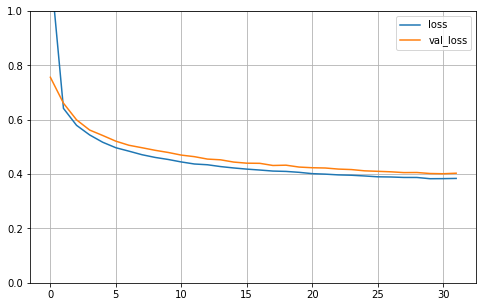

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [16]:
from scipy.stats import reciprocal  # 定义搜索空间
# f(x) = 1/(x*log(b/a)) a <= x <= b

param_distribution = {
    "hidden_layers": [1, 2, 3, 4],
    "layer_size": np.arange(1, 100),
    "learning_rate": reciprocal(1e-4, 1e-2)
}

# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
random_search_cv = RandomizedSearchCV(sklearn_model, param_distribution,
                                      n_iter=10, n_jobs=1)
random_search_cv.fit(xtrain_scaled, ytrain, epochs=100,
                     validation_data=(xvalid_scaled, yvalid),
                     callbacks=callbacks)

# 会使用 cross_validation

Epoch 1/100
291/291 [==============================] - 0s 946us/step - loss: 1.3607 - val_loss: 0.6981
Epoch 2/100
291/291 [==============================] - 0s 743us/step - loss: 0.6506 - val_loss: 0.6720
Epoch 3/100
291/291 [==============================] - 0s 746us/step - loss: 0.5866 - val_loss: 0.6409
Epoch 4/100
291/291 [==============================] - 0s 763us/step - loss: 0.5686 - val_loss: 0.5851
Epoch 5/100
291/291 [==============================] - 0s 766us/step - loss: 0.5210 - val_loss: 0.5291
Epoch 6/100
291/291 [==============================] - 0s 759us/step - loss: 0.5012 - val_loss: 0.5259
Epoch 7/100
291/291 [==============================] - 0s 785us/step - loss: 0.4827 - val_loss: 0.4910
Epoch 8/100
291/291 [==============================] - 0s 738us/step - loss: 0.4754 - val_loss: 0.4852
Epoch 9/100
291/291 [==============================] - 0s 768us/step - loss: 0.4579 - val_loss: 0.4707
Epoch 10/100
291/291 [==============================] - 0s 763us/step - l

291/291 [==============================] - 0s 1ms/step - loss: 0.4190 - val_loss: 0.4322
Epoch 19/100
291/291 [==============================] - 0s 990us/step - loss: 0.4135 - val_loss: 0.4273
Epoch 20/100
291/291 [==============================] - 0s 962us/step - loss: 0.4077 - val_loss: 0.4224
Epoch 21/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4016 - val_loss: 0.4196
Epoch 22/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4002 - val_loss: 0.4193
Epoch 23/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3954 - val_loss: 0.4126
Epoch 24/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3938 - val_loss: 0.4090
Epoch 25/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3932 - val_loss: 0.4139
Epoch 26/100
291/291 [==============================] - 0s 897us/step - loss: 0.3905 - val_loss: 0.4060
Epoch 27/100
291/291 [==============================] - 0s 789us/step - loss: 0.3890 - va

291/291 [==============================] - 0s 932us/step - loss: 0.9928 - val_loss: 0.9931
Epoch 8/100
291/291 [==============================] - 0s 987us/step - loss: 0.9250 - val_loss: 0.9358
Epoch 9/100
291/291 [==============================] - 0s 939us/step - loss: 0.8764 - val_loss: 0.8945
Epoch 10/100
291/291 [==============================] - 0s 925us/step - loss: 0.8407 - val_loss: 0.8635
Epoch 11/100
291/291 [==============================] - 0s 902us/step - loss: 0.8133 - val_loss: 0.8392
Epoch 12/100
291/291 [==============================] - 0s 915us/step - loss: 0.7915 - val_loss: 0.8195
Epoch 13/100
291/291 [==============================] - 0s 917us/step - loss: 0.7736 - val_loss: 0.8029
Epoch 14/100
291/291 [==============================] - 0s 955us/step - loss: 0.7586 - val_loss: 0.7889
Epoch 15/100
291/291 [==============================] - 0s 945us/step - loss: 0.7457 - val_loss: 0.7767
Epoch 16/100
291/291 [==============================] - 0s 915us/step - loss: 0

291/291 [==============================] - 0s 949us/step - loss: 0.5008 - val_loss: 0.5202
Epoch 87/100
291/291 [==============================] - 0s 921us/step - loss: 0.4990 - val_loss: 0.5183
Epoch 88/100
291/291 [==============================] - 0s 967us/step - loss: 0.4973 - val_loss: 0.5163
Epoch 89/100
291/291 [==============================] - 0s 923us/step - loss: 0.4955 - val_loss: 0.5144
Epoch 90/100
73/73 [==============================] - 0s 631us/step - loss: 0.4472
Epoch 1/100
291/291 [==============================] - 0s 1ms/step - loss: 4.9705 - val_loss: 4.5891
Epoch 2/100
291/291 [==============================] - 0s 954us/step - loss: 3.8484 - val_loss: 3.5472
Epoch 3/100
291/291 [==============================] - 0s 914us/step - loss: 2.9499 - val_loss: 2.6898
Epoch 4/100
291/291 [==============================] - 0s 907us/step - loss: 2.2437 - val_loss: 2.0453
Epoch 5/100
291/291 [==============================] - 0s 911us/step - loss: 1.7511 - val_loss: 1.6217
E

291/291 [==============================] - 0s 926us/step - loss: 0.8251 - val_loss: 0.8621
Epoch 12/100
291/291 [==============================] - 0s 947us/step - loss: 0.7854 - val_loss: 0.8242
Epoch 13/100
291/291 [==============================] - 0s 959us/step - loss: 0.7518 - val_loss: 0.7922
Epoch 14/100
291/291 [==============================] - 0s 911us/step - loss: 0.7232 - val_loss: 0.7653
Epoch 15/100
291/291 [==============================] - 0s 919us/step - loss: 0.6995 - val_loss: 0.7427
Epoch 16/100
291/291 [==============================] - 0s 928us/step - loss: 0.6792 - val_loss: 0.7236
Epoch 17/100
291/291 [==============================] - 0s 997us/step - loss: 0.6624 - val_loss: 0.7076
Epoch 18/100
291/291 [==============================] - 0s 945us/step - loss: 0.6483 - val_loss: 0.6943
Epoch 19/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6366 - val_loss: 0.6831
Epoch 20/100
291/291 [==============================] - 0s 937us/step - loss: 0

291/291 [==============================] - 0s 988us/step - loss: 0.6684 - val_loss: 0.7301
Epoch 24/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6618 - val_loss: 0.7223
Epoch 25/100
291/291 [==============================] - 0s 962us/step - loss: 0.6560 - val_loss: 0.7156
Epoch 26/100
291/291 [==============================] - 0s 1000us/step - loss: 0.6505 - val_loss: 0.7102
Epoch 27/100
291/291 [==============================] - 0s 980us/step - loss: 0.6457 - val_loss: 0.7046
Epoch 28/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6411 - val_loss: 0.6992
Epoch 29/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6368 - val_loss: 0.6946
Epoch 30/100
291/291 [==============================] - 0s 988us/step - loss: 0.6328 - val_loss: 0.6901
Epoch 31/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6289 - val_loss: 0.6859
Epoch 32/100
291/291 [==============================] - 0s 938us/step - loss: 0.6253

Epoch 18/100
291/291 [==============================] - 0s 829us/step - loss: 0.8322 - val_loss: 0.8742
Epoch 19/100
291/291 [==============================] - 0s 827us/step - loss: 0.8029 - val_loss: 0.8454
Epoch 20/100
291/291 [==============================] - 0s 821us/step - loss: 0.7760 - val_loss: 0.8187
Epoch 21/100
291/291 [==============================] - 0s 855us/step - loss: 0.7515 - val_loss: 0.7954
Epoch 22/100
291/291 [==============================] - 0s 832us/step - loss: 0.7300 - val_loss: 0.7740
Epoch 23/100
291/291 [==============================] - 0s 828us/step - loss: 0.7110 - val_loss: 0.7556
Epoch 24/100
291/291 [==============================] - 0s 845us/step - loss: 0.6941 - val_loss: 0.7394
Epoch 25/100
291/291 [==============================] - 0s 870us/step - loss: 0.6794 - val_loss: 0.7250
Epoch 26/100
291/291 [==============================] - 0s 870us/step - loss: 0.6666 - val_loss: 0.7125
Epoch 27/100
291/291 [==============================] - 0s 868us

291/291 [==============================] - 0s 983us/step - loss: 0.5862 - val_loss: 0.6228
Epoch 25/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5813 - val_loss: 0.6179
Epoch 26/100
291/291 [==============================] - 0s 959us/step - loss: 0.5767 - val_loss: 0.6131
Epoch 27/100
291/291 [==============================] - 0s 911us/step - loss: 0.5723 - val_loss: 0.6085
Epoch 28/100
291/291 [==============================] - 0s 904us/step - loss: 0.5681 - val_loss: 0.6040
Epoch 29/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5640 - val_loss: 0.5995
Epoch 30/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5603 - val_loss: 0.5954
Epoch 31/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5565 - val_loss: 0.5914
Epoch 32/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5529 - val_loss: 0.5877
Epoch 33/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5495 - va

291/291 [==============================] - 0s 973us/step - loss: 0.5565 - val_loss: 0.5969
Epoch 41/100
291/291 [==============================] - 0s 970us/step - loss: 0.5531 - val_loss: 0.5932
Epoch 42/100
291/291 [==============================] - 0s 962us/step - loss: 0.5498 - val_loss: 0.5897
Epoch 43/100
291/291 [==============================] - 0s 970us/step - loss: 0.5465 - val_loss: 0.5863
Epoch 44/100
291/291 [==============================] - 0s 963us/step - loss: 0.5433 - val_loss: 0.5831
Epoch 45/100
291/291 [==============================] - 0s 971us/step - loss: 0.5401 - val_loss: 0.5797
Epoch 46/100
291/291 [==============================] - 0s 988us/step - loss: 0.5370 - val_loss: 0.5764
Epoch 47/100
291/291 [==============================] - 0s 946us/step - loss: 0.5340 - val_loss: 0.5732
Epoch 48/100
291/291 [==============================] - 0s 985us/step - loss: 0.5310 - val_loss: 0.5701
Epoch 49/100
291/291 [==============================] - 0s 1ms/step - loss: 0

Epoch 39/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5574 - val_loss: 0.6035
Epoch 40/100
291/291 [==============================] - 0s 983us/step - loss: 0.5544 - val_loss: 0.6005
Epoch 41/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5518 - val_loss: 0.5973
Epoch 42/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5490 - val_loss: 0.5944
Epoch 43/100
291/291 [==============================] - 0s 938us/step - loss: 0.5462 - val_loss: 0.5916
Epoch 44/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5437 - val_loss: 0.5887
Epoch 45/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5411 - val_loss: 0.5860
Epoch 46/100
291/291 [==============================] - 0s 955us/step - loss: 0.5387 - val_loss: 0.5833
Epoch 47/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5363 - val_loss: 0.5807
Epoch 48/100
291/291 [==============================] - 0s 985us/step - loss

291/291 [==============================] - 0s 965us/step - loss: 0.5131 - val_loss: 0.5614
Epoch 49/100
291/291 [==============================] - 0s 983us/step - loss: 0.5109 - val_loss: 0.5587
Epoch 50/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5087 - val_loss: 0.5561
Epoch 51/100
291/291 [==============================] - 0s 900us/step - loss: 0.5067 - val_loss: 0.5534
Epoch 52/100
291/291 [==============================] - 0s 926us/step - loss: 0.5047 - val_loss: 0.5509
Epoch 53/100
291/291 [==============================] - 0s 913us/step - loss: 0.5026 - val_loss: 0.5487
Epoch 54/100
291/291 [==============================] - 0s 931us/step - loss: 0.5007 - val_loss: 0.5463
Epoch 55/100
291/291 [==============================] - 0s 977us/step - loss: 0.4989 - val_loss: 0.5438
Epoch 56/100
291/291 [==============================] - 0s 936us/step - loss: 0.4970 - val_loss: 0.5413
Epoch 57/100
291/291 [==============================] - 0s 890us/step - loss: 0

Epoch 61/100
291/291 [==============================] - 0s 866us/step - loss: 0.4909 - val_loss: 0.5305
Epoch 62/100
291/291 [==============================] - 0s 863us/step - loss: 0.4888 - val_loss: 0.5281
Epoch 63/100
291/291 [==============================] - 0s 845us/step - loss: 0.4868 - val_loss: 0.5259
Epoch 64/100
291/291 [==============================] - 0s 873us/step - loss: 0.4849 - val_loss: 0.5237
Epoch 65/100
291/291 [==============================] - 0s 852us/step - loss: 0.4829 - val_loss: 0.5216
Epoch 66/100
291/291 [==============================] - 0s 859us/step - loss: 0.4811 - val_loss: 0.5196
Epoch 67/100
291/291 [==============================] - 0s 845us/step - loss: 0.4792 - val_loss: 0.5173
Epoch 68/100
291/291 [==============================] - 0s 873us/step - loss: 0.4774 - val_loss: 0.5153
Epoch 69/100
291/291 [==============================] - 0s 844us/step - loss: 0.4757 - val_loss: 0.5134
Epoch 70/100
291/291 [==============================] - 0s 852us

291/291 [==============================] - 0s 808us/step - loss: 0.8868 - val_loss: 0.9063
Epoch 8/100
291/291 [==============================] - 0s 811us/step - loss: 0.8367 - val_loss: 0.8687
Epoch 9/100
291/291 [==============================] - 0s 797us/step - loss: 0.8026 - val_loss: 0.8399
Epoch 10/100
291/291 [==============================] - 0s 821us/step - loss: 0.7768 - val_loss: 0.8181
Epoch 11/100
291/291 [==============================] - 0s 797us/step - loss: 0.7562 - val_loss: 0.8000
Epoch 12/100
291/291 [==============================] - 0s 828us/step - loss: 0.7390 - val_loss: 0.7847
Epoch 13/100
291/291 [==============================] - 0s 797us/step - loss: 0.7242 - val_loss: 0.7712
Epoch 14/100
291/291 [==============================] - 0s 797us/step - loss: 0.7112 - val_loss: 0.7588
Epoch 15/100
291/291 [==============================] - 0s 863us/step - loss: 0.6993 - val_loss: 0.7475
Epoch 16/100
291/291 [==============================] - 0s 828us/step - loss: 0

291/291 [==============================] - 0s 835us/step - loss: 0.8497 - val_loss: 0.8839
Epoch 8/100
291/291 [==============================] - 0s 821us/step - loss: 0.8030 - val_loss: 0.8441
Epoch 9/100
291/291 [==============================] - 0s 818us/step - loss: 0.7700 - val_loss: 0.8157
Epoch 10/100
291/291 [==============================] - 0s 818us/step - loss: 0.7460 - val_loss: 0.7939
Epoch 11/100
291/291 [==============================] - 0s 811us/step - loss: 0.7275 - val_loss: 0.7764
Epoch 12/100
291/291 [==============================] - 0s 804us/step - loss: 0.7123 - val_loss: 0.7624
Epoch 13/100
291/291 [==============================] - 0s 814us/step - loss: 0.7000 - val_loss: 0.7495
Epoch 14/100
291/291 [==============================] - 0s 797us/step - loss: 0.6889 - val_loss: 0.7385
Epoch 15/100
291/291 [==============================] - 0s 811us/step - loss: 0.6791 - val_loss: 0.7284
Epoch 16/100
291/291 [==============================] - 0s 825us/step - loss: 0

291/291 [==============================] - 0s 1ms/step - loss: 0.6070 - val_loss: 0.6666
Epoch 17/100
291/291 [==============================] - 0s 952us/step - loss: 0.6002 - val_loss: 0.6600
Epoch 18/100
291/291 [==============================] - 0s 883us/step - loss: 0.5939 - val_loss: 0.6539
Epoch 19/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5880 - val_loss: 0.6473
Epoch 20/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5823 - val_loss: 0.6413
Epoch 21/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5770 - val_loss: 0.6357
Epoch 22/100
291/291 [==============================] - 0s 986us/step - loss: 0.5719 - val_loss: 0.6301
Epoch 23/100
291/291 [==============================] - 0s 869us/step - loss: 0.5670 - val_loss: 0.6249
Epoch 24/100
291/291 [==============================] - 0s 973us/step - loss: 0.5623 - val_loss: 0.6195
Epoch 25/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5578 - 

291/291 [==============================] - 1s 3ms/step - loss: 0.5581 - val_loss: 0.5999
Epoch 29/100
291/291 [==============================] - 1s 3ms/step - loss: 0.5531 - val_loss: 0.5945
Epoch 30/100
291/291 [==============================] - 1s 3ms/step - loss: 0.5483 - val_loss: 0.5916
Epoch 31/100
291/291 [==============================] - 1s 3ms/step - loss: 0.5439 - val_loss: 0.5849
Epoch 32/100
291/291 [==============================] - 1s 3ms/step - loss: 0.5393 - val_loss: 0.5797
Epoch 33/100
291/291 [==============================] - 1s 3ms/step - loss: 0.5347 - val_loss: 0.5748
Epoch 34/100
291/291 [==============================] - 1s 3ms/step - loss: 0.5305 - val_loss: 0.5701
Epoch 35/100
291/291 [==============================] - 1s 3ms/step - loss: 0.5263 - val_loss: 0.5655
Epoch 36/100
291/291 [==============================] - 1s 3ms/step - loss: 0.5222 - val_loss: 0.5610
Epoch 37/100
291/291 [==============================] - 1s 3ms/step - loss: 0.5184 - val_loss: 

291/291 [==============================] - 2567s 9s/step - loss: 0.5723 - val_loss: 0.6086
Epoch 41/100
291/291 [==============================] - 1s 2ms/step - loss: 0.5691 - val_loss: 0.6051
Epoch 42/100
291/291 [==============================] - 1s 2ms/step - loss: 0.5658 - val_loss: 0.6015
Epoch 43/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5627 - val_loss: 0.5982
Epoch 44/100
291/291 [==============================] - 0s 947us/step - loss: 0.5596 - val_loss: 0.5950
Epoch 45/100
291/291 [==============================] - 0s 843us/step - loss: 0.5566 - val_loss: 0.5916
Epoch 46/100
291/291 [==============================] - 1s 2ms/step - loss: 0.5537 - val_loss: 0.5885
Epoch 47/100
291/291 [==============================] - 0s 952us/step - loss: 0.5508 - val_loss: 0.5855
Epoch 48/100
291/291 [==============================] - 0s 958us/step - loss: 0.5480 - val_loss: 0.5824
Epoch 49/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5452 - 

291/291 [==============================] - 0s 1ms/step - loss: 0.5619 - val_loss: 0.6059
Epoch 41/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5583 - val_loss: 0.6021
Epoch 42/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5548 - val_loss: 0.5985
Epoch 43/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5514 - val_loss: 0.5949
Epoch 44/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5482 - val_loss: 0.5914
Epoch 45/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5450 - val_loss: 0.5880
Epoch 46/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5418 - val_loss: 0.5847
Epoch 47/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5388 - val_loss: 0.5814
Epoch 48/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5358 - val_loss: 0.5782
Epoch 49/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5329 - val_loss: 

291/291 [==============================] - 0s 1ms/step - loss: 0.5498 - val_loss: 0.5936
Epoch 48/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5471 - val_loss: 0.5907
Epoch 49/100
291/291 [==============================] - 1s 2ms/step - loss: 0.5445 - val_loss: 0.5879
Epoch 50/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5419 - val_loss: 0.5850
Epoch 51/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5394 - val_loss: 0.5823
Epoch 52/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5370 - val_loss: 0.5796
Epoch 53/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5346 - val_loss: 0.5771
Epoch 54/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5322 - val_loss: 0.5745
Epoch 55/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5300 - val_loss: 0.5719
Epoch 56/100
291/291 [==============================] - 0s 888us/step - loss: 0.5277 - val_loss

291/291 [==============================] - 0s 928us/step - loss: 0.5672 - val_loss: 0.6261
Epoch 50/100
291/291 [==============================] - 0s 922us/step - loss: 0.5640 - val_loss: 0.6226
Epoch 51/100
291/291 [==============================] - 0s 887us/step - loss: 0.5609 - val_loss: 0.6189
Epoch 52/100
291/291 [==============================] - 0s 1000us/step - loss: 0.5578 - val_loss: 0.6159
Epoch 53/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5548 - val_loss: 0.6123
Epoch 54/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5518 - val_loss: 0.6093
Epoch 55/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5489 - val_loss: 0.6058
Epoch 56/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5460 - val_loss: 0.6020
Epoch 57/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5431 - val_loss: 0.5992
Epoch 58/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5404 - v

291/291 [==============================] - 0s 1ms/step - loss: 0.5770 - val_loss: 0.6336
Epoch 34/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5728 - val_loss: 0.6291
Epoch 35/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5687 - val_loss: 0.6247
Epoch 36/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5647 - val_loss: 0.6204
Epoch 37/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5608 - val_loss: 0.6162
Epoch 38/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5570 - val_loss: 0.6120
Epoch 39/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5533 - val_loss: 0.6079
Epoch 40/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5496 - val_loss: 0.6038
Epoch 41/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5460 - val_loss: 0.5998
Epoch 42/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5425 - val_loss: 

291/291 [==============================] - 0s 1ms/step - loss: 0.4584 - val_loss: 0.4740
Epoch 35/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4549 - val_loss: 0.4706
Epoch 36/100
291/291 [==============================] - 0s 2ms/step - loss: 0.4519 - val_loss: 0.4668
Epoch 37/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4489 - val_loss: 0.4636
Epoch 38/100
291/291 [==============================] - 0s 2ms/step - loss: 0.4455 - val_loss: 0.4608
Epoch 39/100
291/291 [==============================] - 0s 2ms/step - loss: 0.4430 - val_loss: 0.4578
Epoch 40/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4402 - val_loss: 0.4552
Epoch 41/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4377 - val_loss: 0.4516
Epoch 42/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4352 - val_loss: 0.4514
Epoch 43/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4329 - val_loss: 

291/291 [==============================] - 0s 1ms/step - loss: 0.6119 - val_loss: 0.6447
Epoch 9/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5919 - val_loss: 0.6245
Epoch 10/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5767 - val_loss: 0.6101
Epoch 11/100
291/291 [==============================] - 0s 975us/step - loss: 0.5645 - val_loss: 0.5989
Epoch 12/100
291/291 [==============================] - 0s 945us/step - loss: 0.5543 - val_loss: 0.5881
Epoch 13/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5449 - val_loss: 0.5798
Epoch 14/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5368 - val_loss: 0.5707
Epoch 15/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5290 - val_loss: 0.5613
Epoch 16/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5212 - val_loss: 0.5535
Epoch 17/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5137 - val_los

291/291 [==============================] - 0s 1ms/step - loss: 0.5662 - val_loss: 0.6114
Epoch 8/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5510 - val_loss: 0.5959
Epoch 9/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5383 - val_loss: 0.5859
Epoch 10/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5271 - val_loss: 0.5713
Epoch 11/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5181 - val_loss: 0.5671
Epoch 12/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5099 - val_loss: 0.5553
Epoch 13/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5021 - val_loss: 0.5418
Epoch 14/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4962 - val_loss: 0.5437
Epoch 15/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4896 - val_loss: 0.5293
Epoch 16/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4843 - val_loss: 0.

291/291 [==============================] - 0s 1ms/step - loss: 0.3541 - val_loss: 0.3654
Epoch 11/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3484 - val_loss: 0.3709
Epoch 12/100
291/291 [==============================] - 0s 2ms/step - loss: 0.3464 - val_loss: 0.3610
Epoch 13/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3492 - val_loss: 0.3584
Epoch 14/100
73/73 [==============================] - 0s 658us/step - loss: 0.3702
Epoch 1/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8334 - val_loss: 0.9567
Epoch 2/100
291/291 [==============================] - 0s 2ms/step - loss: 1.3948 - val_loss: 0.7499
Epoch 3/100
291/291 [==============================] - 0s 970us/step - loss: 1.0269 - val_loss: 1.1976
Epoch 4/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5793 - val_loss: 0.4084
Epoch 5/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3684 - val_loss: 0.3841
Epoch 6/100
291

291/291 [==============================] - 0s 816us/step - loss: 0.4828 - val_loss: 0.5053
Epoch 7/100
291/291 [==============================] - 0s 955us/step - loss: 0.4645 - val_loss: 0.4865
Epoch 8/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4498 - val_loss: 0.4718
Epoch 9/100
291/291 [==============================] - 0s 946us/step - loss: 0.4393 - val_loss: 0.4609
Epoch 10/100
291/291 [==============================] - 0s 931us/step - loss: 0.4303 - val_loss: 0.4533
Epoch 11/100
291/291 [==============================] - 0s 995us/step - loss: 0.4232 - val_loss: 0.4447
Epoch 12/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4174 - val_loss: 0.4371
Epoch 13/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4113 - val_loss: 0.4303
Epoch 14/100
291/291 [==============================] - 0s 835us/step - loss: 0.4066 - val_loss: 0.4290
Epoch 15/100
291/291 [==============================] - 0s 958us/step - loss: 0.4022 -

291/291 [==============================] - 0s 886us/step - loss: 0.4259 - val_loss: 0.4513
Epoch 12/100
291/291 [==============================] - 0s 978us/step - loss: 0.4161 - val_loss: 0.4403
Epoch 13/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4082 - val_loss: 0.4309
Epoch 14/100
291/291 [==============================] - 0s 988us/step - loss: 0.4012 - val_loss: 0.4216
Epoch 15/100
291/291 [==============================] - 0s 961us/step - loss: 0.3943 - val_loss: 0.4163
Epoch 16/100
291/291 [==============================] - 0s 955us/step - loss: 0.3904 - val_loss: 0.4088
Epoch 17/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3855 - val_loss: 0.4197
Epoch 18/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3825 - val_loss: 0.3987
Epoch 19/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3789 - val_loss: 0.3972
Epoch 20/100
291/291 [==============================] - 0s 993us/step - loss: 0.3756 

Epoch 26/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4247 - val_loss: 0.4420
Epoch 27/100
291/291 [==============================] - 0s 930us/step - loss: 0.4206 - val_loss: 0.4383
Epoch 28/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4168 - val_loss: 0.4330
Epoch 29/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4135 - val_loss: 0.4289
Epoch 30/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4101 - val_loss: 0.4266
Epoch 31/100
291/291 [==============================] - 0s 2ms/step - loss: 0.4069 - val_loss: 0.4225
Epoch 32/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4038 - val_loss: 0.4201
Epoch 33/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4007 - val_loss: 0.4165
Epoch 34/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3983 - val_loss: 0.4139
Epoch 35/100
291/291 [==============================] - 0s 1ms/step - loss: 0.39

Epoch 10/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5492 - val_loss: 0.5856
Epoch 11/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5358 - val_loss: 0.5708
Epoch 12/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5229 - val_loss: 0.5572
Epoch 13/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5111 - val_loss: 0.5448
Epoch 14/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5002 - val_loss: 0.5338
Epoch 15/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4903 - val_loss: 0.5264
Epoch 16/100
291/291 [==============================] - 0s 2ms/step - loss: 0.4818 - val_loss: 0.5136
Epoch 17/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4736 - val_loss: 0.5051
Epoch 18/100
291/291 [==============================] - 0s 882us/step - loss: 0.4659 - val_loss: 0.4966
Epoch 19/100
291/291 [==============================] - 0s 1ms/step - loss: 0.45

291/291 [==============================] - 0s 1ms/step - loss: 0.3847 - val_loss: 0.4116
Epoch 40/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3830 - val_loss: 0.4089
Epoch 41/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3811 - val_loss: 0.4085
Epoch 42/100
291/291 [==============================] - 0s 935us/step - loss: 0.3796 - val_loss: 0.4049
Epoch 43/100
73/73 [==============================] - 0s 934us/step - loss: 0.4015
Epoch 1/100
291/291 [==============================] - 0s 2ms/step - loss: 2.7580 - val_loss: 1.4082
Epoch 2/100
291/291 [==============================] - 0s 1ms/step - loss: 1.0717 - val_loss: 0.8755
Epoch 3/100
291/291 [==============================] - 0s 981us/step - loss: 0.7487 - val_loss: 0.7217
Epoch 4/100
291/291 [==============================] - 0s 2ms/step - loss: 0.6505 - val_loss: 0.6717
Epoch 5/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6134 - val_loss: 0.6484
Epoch 6/100
2

Epoch 29/100
291/291 [==============================] - 0s 1ms/step - loss: 0.9126 - val_loss: 0.9504
Epoch 30/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8913 - val_loss: 0.9294
Epoch 31/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8716 - val_loss: 0.9105
Epoch 32/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8537 - val_loss: 0.8933
Epoch 33/100
291/291 [==============================] - 0s 901us/step - loss: 0.8374 - val_loss: 0.8780
Epoch 34/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8227 - val_loss: 0.8643
Epoch 35/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8096 - val_loss: 0.8520
Epoch 36/100
291/291 [==============================] - 0s 938us/step - loss: 0.7977 - val_loss: 0.8410
Epoch 37/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7871 - val_loss: 0.8313
Epoch 38/100
291/291 [==============================] - 0s 974us/step - loss: 

291/291 [==============================] - 0s 836us/step - loss: 0.6862 - val_loss: 0.7397
Epoch 42/100
291/291 [==============================] - 0s 943us/step - loss: 0.6828 - val_loss: 0.7364
Epoch 43/100
291/291 [==============================] - 0s 701us/step - loss: 0.6794 - val_loss: 0.7331
Epoch 44/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6761 - val_loss: 0.7298
Epoch 45/100
291/291 [==============================] - 0s 730us/step - loss: 0.6730 - val_loss: 0.7267
Epoch 46/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6699 - val_loss: 0.7235
Epoch 47/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6669 - val_loss: 0.7205
Epoch 48/100
291/291 [==============================] - 1s 2ms/step - loss: 0.6640 - val_loss: 0.7177
Epoch 49/100
291/291 [==============================] - 0s 2ms/step - loss: 0.6613 - val_loss: 0.7148
Epoch 50/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6585 - va

291/291 [==============================] - 0s 1ms/step - loss: 0.6884 - val_loss: 0.7262
Epoch 49/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6851 - val_loss: 0.7233
Epoch 50/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6819 - val_loss: 0.7204
Epoch 51/100
291/291 [==============================] - 0s 838us/step - loss: 0.6788 - val_loss: 0.7176
Epoch 52/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6758 - val_loss: 0.7149
Epoch 53/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6729 - val_loss: 0.7122
Epoch 54/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6700 - val_loss: 0.7095
Epoch 55/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6672 - val_loss: 0.7069
Epoch 56/100
291/291 [==============================] - 0s 860us/step - loss: 0.6644 - val_loss: 0.7043
Epoch 57/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6617 - val_lo

291/291 [==============================] - 0s 1ms/step - loss: 0.6947 - val_loss: 0.7391
Epoch 30/100
291/291 [==============================] - 0s 910us/step - loss: 0.6839 - val_loss: 0.7285
Epoch 31/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6737 - val_loss: 0.7186
Epoch 32/100
291/291 [==============================] - 0s 687us/step - loss: 0.6640 - val_loss: 0.7093
Epoch 33/100
291/291 [==============================] - 0s 940us/step - loss: 0.6548 - val_loss: 0.7004
Epoch 34/100
291/291 [==============================] - 0s 800us/step - loss: 0.6462 - val_loss: 0.6920
Epoch 35/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6381 - val_loss: 0.6839
Epoch 36/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6305 - val_loss: 0.6763
Epoch 37/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6234 - val_loss: 0.6691
Epoch 38/100
291/291 [==============================] - 0s 982us/step - loss: 0.6166 - 

Epoch 28/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7628 - val_loss: 0.8082
Epoch 29/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7565 - val_loss: 0.8018
Epoch 30/100
291/291 [==============================] - 0s 739us/step - loss: 0.7505 - val_loss: 0.7957
Epoch 31/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7448 - val_loss: 0.7899
Epoch 32/100
291/291 [==============================] - 0s 755us/step - loss: 0.7395 - val_loss: 0.7844
Epoch 33/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7344 - val_loss: 0.7793
Epoch 34/100
291/291 [==============================] - 0s 921us/step - loss: 0.7297 - val_loss: 0.7744
Epoch 35/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7250 - val_loss: 0.7697
Epoch 36/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7205 - val_loss: 0.7653
Epoch 37/100
291/291 [==============================] - 0s 1ms/step - loss: 

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001C537018400>, as the constructor either does not set or modifies parameter layer_size

In [ ]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

In [ ]:
model = random_search_cv.best_estimator_.model
model.evaluate(xtest_scaled, ytest)